<a href="https://colab.research.google.com/github/narrasriram/EMOTION-RECOGNITION-USING-FINE-TUNED-MODELS-ERFM-/blob/main/Colab%20Model%20building%20Files/Regression/Models%20on%20Emotion%20Stimulus%20Dataset/Fine-tuning%20ALBERT/Fine_tuning_Albert_for_Regression_Analysis_Emotion_Stimulus_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  
# -*- coding: utf-8 -*-

# Author: Sriram Narra
# Course: CS 842
# Date: Apr 15, 2021
# Project Name: Emotion Recognition using Fine-tuned Models(ERFM)
# Description: This notebook builds a Fine-tuned ALBERT Model on Emotion 
#              Stimulus Dataset and checks the performance of the 
#              model with various model evaluation metrics
# --------------------------------------------------------------------------------

In [ ]:
!pip install transformers==3.1.0

     |████████████████████████████████| 890kB 5.9MB/s 
     |████████████████████████████████| 870kB 36.2MB/s 
     |████████████████████████████████| 3.0MB 31.8MB/s 
     |████████████████████████████████| 1.2MB 43.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e4b9362ed6a72b4c3494722b541bb92ab483cfc0eaacc4a5686c0765ddf2147f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


Importing the libraries

In [ ]:
from transformers import AlbertTokenizer
from transformers import TFAlbertForSequenceClassification

import tensorflow as tf
import json

from pandas import DataFrame
import textblob
from textblob import TextBlob
import pandas as pd


Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Read the Data into a list

In [ ]:
with open('/content/drive/MyDrive/Data Science Project/Datasets/Emotion_Stimulus/No_Cause.txt') as f:
    conversations = f.readlines()

# Print the type of object data is saved in and 
# Print first 2 samples in the object
print("Type of Class: "+str(type(conversations)))
conversations[0:2]

Type of Class: <class 'list'>


['<happy>This did the trick : the boys now have a more distant friendship and David is much happier . <\\happy>\n',
 '<happy>When Anna left Inspector Aziz , she was much happier . <\\happy>\n']

In [ ]:
type(conversations)

list

Data Transformation into Dictionary with Sentences as Key and Values as Emotions

In [ ]:
import re
from bs4 import BeautifulSoup

data = {}

for line in conversations:
    # Retrieve the Emotion Label data present in "<...>"" tag
    result = re.search(r"<[a-zA-z]+>", line)
    emotion = result.group(0)
    emotion  = emotion[1:(len(emotion)-1)]
    
    # Retrieve the Sentence without emotion tags 
    soup = BeautifulSoup(line)
    x = soup.findAll(emotion)

    # Remove the trailing spaces in the retrieved sentences
    txt = ''.join(x[0].findAll(text=True)).strip()

    # Store the sentence in dictionary as key and label as value
    data[txt] = emotion

# Print first two elements in dictionary
list(data.items())[:2]

[('This did the trick : the boys now have a more distant friendship and David is much happier .',
  'happy'),
 ('When Anna left Inspector Aziz , she was much happier .', 'happy')]

In [ ]:
print(list(data.items())[:2])

[('This did the trick : the boys now have a more distant friendship and David is much happier .', 'happy'), ('When Anna left Inspector Aziz , she was much happier .', 'happy')]


Data Transformation into Dataframe

In [ ]:
data_frame = DataFrame(data.items(), columns=['Sentence', 'Emotion'])
data_frame.head()

,Sentence,Emotion
0,This did the trick : the boys now have a more ...,happy
1,"When Anna left Inspector Aziz , she was much h...",happy
2,"And though , as Lachlan had planned , they had...",happy
3,"Honestly , I 'm really happy for you !",happy
4,Lesley was totally happy about it .,happy


Label Encoding the Emotion Column

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_frame['Emotion'] = le.fit_transform(data_frame['Emotion'])
data_frame.head()

,Sentence,Emotion
0,This did the trick : the boys now have a more ...,3
1,"When Anna left Inspector Aziz , she was much h...",3
2,"And though , as Lachlan had planned , they had...",3
3,"Honestly , I 'm really happy for you !",3
4,Lesley was totally happy about it .,3


In [ ]:
data_frame.Emotion.unique()

array([3, 4, 2, 6, 1, 0, 5])

In [ ]:
list(le.inverse_transform([0,1,2,3,4,5,6]))

['anger', 'disgust', 'fear', 'happy', 'sad', 'shame', 'surprise']

In [ ]:
data_frame = data_frame.sample(frac=1).reset_index(drop=True)
data_frame.head()

,Sentence,Emotion
0,He paused as his mother stared at him in bewil...,6
1,If she had been paying more attention to his f...,4
2,He gave a little grunt of exasperation .,0
3,The grief-stricken widow refused to leave her ...,4
4,When they got to the florist and Georg saw his...,0


Missing Values Analysis

In [ ]:
data_frame.isnull().values.any()

False

Subjectivity Score Assignment

In [ ]:
from textblob import TextBlob

def getScore(data):
  return TextBlob(data).sentiment.subjectivity

data_frame["Subj_Score"] = data_frame["Sentence"].apply(getScore)
data_frame.head()

,Sentence,Emotion,Subj_Score
0,He paused as his mother stared at him in bewil...,6,0.000000
1,If she had been paying more attention to his f...,4,0.650000
2,He gave a little grunt of exasperation .,0,0.500000
3,The grief-stricken widow refused to leave her ...,4,0.400000
4,When they got to the florist and Georg saw his...,0,0.066667


Outlier Analysis

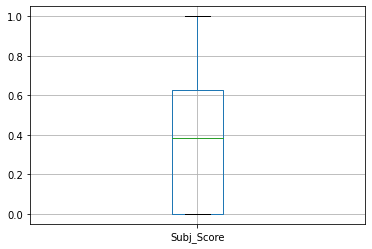

In [ ]:
boxplot = data_frame.boxplot(column=['Subj_Score'])

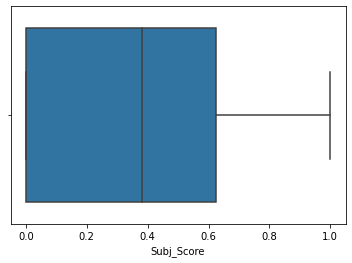

In [ ]:
import seaborn as sns
sns.boxplot(x=data_frame['Subj_Score'])

Balanced/Imbalanced Data check on Subjectivity Score Bins

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbeea94e90>]],
      dtype=object)

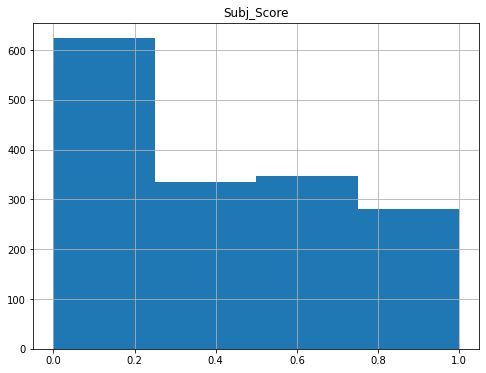

In [ ]:
data_frame.hist(column=['Subj_Score'],bins=4, figsize=(8,6))

Balancing the Imbalanced Dataset based on Subjectivity Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbeea7e1d0>]],
      dtype=object)

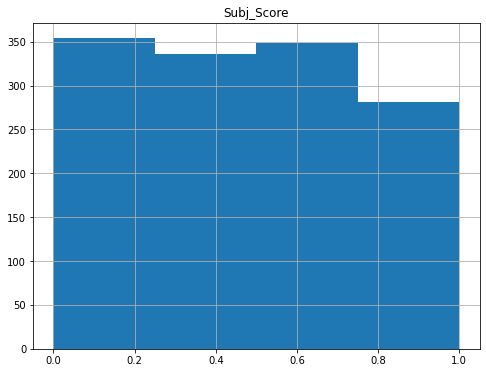

In [ ]:
count = 1
columns = ['Sentence','Emotion', 'Subj_Score']
zero_df = None
zero_df = pd.DataFrame(columns=columns)

for index, row in data_frame.iterrows():
  if(row['Subj_Score']==0.0 and count<=270):
    #print("entered")
    zero_df.loc[data_frame.index[index]] = data_frame.iloc[index]
    count+=1

cond = data_frame['Sentence'].isin(zero_df['Sentence'])
data_frame.drop(data_frame[cond].index, inplace = True)
data_frame.hist(column=['Subj_Score'],bins=4, figsize=(8,6))

In [ ]:
data_frame = data_frame.sample(frac=1).reset_index(drop=True)
data_frame.head()

,Sentence,Emotion,Subj_Score
0,But the STUC also voiced disquiet about the wa...,2,0.066667
1,"From somewhere in the gloom , accompanied by r...",4,0.300000
2,I kept trying to get back to Changez 's lugubr...,4,0.500000
3,"He had a narrow mournful face , tapering to a ...",4,0.400000
4,"` Well , he was pleased when you agreed to this .",3,1.000000


Balanced/Imbalanced Emotion Label Analysis of the Dataset

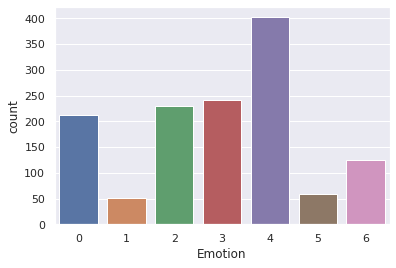

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Emotion", data=data_frame)

In [ ]:
int(0.7*len(data_frame))+int(0.1*len(data_frame))

1054

Conversion of dataframe column data into list

In [ ]:
sentences_list = data_frame['Sentence'].tolist()
labels_list = data_frame['Subj_Score'].tolist()

Splitting the training, validation and testing data

In [ ]:
train_length = int(0.7*len(data_frame))
validation_length = int(0.7*len(data_frame))+int(0.15*len(data_frame))

train_data = sentences_list[0:train_length]
val_data = sentences_list[train_length:validation_length]
test_data = sentences_list[validation_length:]
extended_data = zero_df['Sentence'].tolist()
test_data.extend(extended_data)
train_scores = labels_list[0:train_length]
val_scores = labels_list[train_length:validation_length]
test_scores = labels_list[validation_length:]
extended_scores = zero_df['Subj_Score'].tolist()
test_scores.extend(extended_scores)

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
#print(zero_df['Sentence'].tolist())

923
197
469


Initializing the AlbertTokenizer instance

In [ ]:
albert_tokens = AlbertTokenizer.from_pretrained('albert-base-v2')

5-fold Cross Validation

In [ ]:
# kfold
from sklearn.model_selection import KFold
kf= KFold(n_splits=5, random_state=None, shuffle=True)
fold_no = 1
losses_array = []
validation_losses_array = []
mse_array = []
validation_mse_array = []
for train_index_list, test_index_list in kf.split(sentences_list):
  x_train_n = [sentences_list[index] for index in train_index_list]
  x_test_n = [sentences_list[index] for index in test_index_list]
  y_train_n = [labels_list[index] for index in train_index_list]
  y_test_n = [labels_list[index] for index in test_index_list]

  #do all the things
  train_tokens_n = albert_tokens(x_train_n,
                            truncation=True,
                            padding=True)
  validation_tokens_n = albert_tokens(x_test_n,
                            truncation=True,
                            padding=True)
  
  model_train_data = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens_n),
    y_train_n
    ))

  model_val_data = tf.data.Dataset.from_tensor_slices((
    dict(validation_tokens_n),
    y_test_n
    ))
  
  albert_regression_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2',
                                                              num_labels=1)
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
  albert_regression_model.compile(optimizer=optimizer, loss=albert_regression_model.compute_loss, metrics=['mean_squared_error'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history= albert_regression_model.fit(model_train_data.shuffle(100).batch(16),
          epochs=8,
          batch_size=16,
          validation_data=model_val_data.shuffle(100).batch(16))

  fold_no = fold_no + 1
  losses_array.append(history.history['loss'])
  validation_losses_array.append(history.history['val_loss'])
  mse_array.append(history.history['mean_squared_error'])
  validation_mse_array.append(history.history['val_mean_squared_error'])
print("K fold validaiton finished..............................")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier', 'dropout_5']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/8
66/66 [==============================] - 33s 296ms/step - loss: 0.1679 - mean_squared_error: 0.1679 - val_loss: 0.0861 - val_mean_squared_error: 0.0861
Epoch 2/8
66/66 [==============================] - 17s 260ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoch 3/8
66/66 [==============================] - 17s 265ms/step - loss: 0.0874 - mean_squared_error: 0.0874 - val_loss: 0.0901 - val_mean_squared_error: 0.0901
Epoch 4/8
66/66 [==============================] - 18s 270ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 5/8
66/66 [==============================] - 18s 269ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0580 - val_mean_squared_error: 0.0580
Epoch 6/8
66/66 [==============================] - 18s 266ms/step - loss: 0.0313 - mean_squar

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['dropout_11', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/8
66/66 [==============================] - 32s 302ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Epoch 2/8
66/66 [==============================] - 18s 272ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - val_loss: 0.1194 - val_mean_squared_error: 0.1194
Epoch 3/8
66/66 [==============================] - 18s 269ms/step - loss: 0.1105 - mean_squared_error: 0.1105 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 4/8
66/66 [==============================] - 17s 265ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0626 - val_mean_squared_error: 0.0626
Epoch 5/8
66/66 [==============================] - 18s 266ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 6/8
66/66 [==============================] - 18s 268ms/step - loss: 0.0423 - mean_squar

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier', 'dropout_17']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/8
66/66 [==============================] - 30s 265ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.0849 - val_mean_squared_error: 0.0849
Epoch 2/8
66/66 [==============================] - 15s 234ms/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 3/8
66/66 [==============================] - 15s 234ms/step - loss: 0.0785 - mean_squared_error: 0.0785 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 4/8
66/66 [==============================] - 15s 232ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 5/8
66/66 [==============================] - 15s 229ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.1369 - val_mean_squared_error: 0.1369
Epoch 6/8
66/66 [==============================] - 15s 229ms/step - loss: 0.0875 - mean_squar

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['dropout_23', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/8
66/66 [==============================] - 32s 301ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.1198 - val_mean_squared_error: 0.1198
Epoch 2/8
66/66 [==============================] - 18s 271ms/step - loss: 0.1012 - mean_squared_error: 0.1012 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 3/8
66/66 [==============================] - 18s 269ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0675 - val_mean_squared_error: 0.0675
Epoch 4/8
66/66 [==============================] - 17s 265ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.1357 - val_mean_squared_error: 0.1357
Epoch 5/8
66/66 [==============================] - 17s 263ms/step - loss: 0.1105 - mean_squared_error: 0.1105 - val_loss: 0.0958 - val_mean_squared_error: 0.0958
Epoch 6/8
66/66 [==============================] - 17s 264ms/step - loss: 0.1031 - mean_squar

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier', 'dropout_29']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/8
66/66 [==============================] - 32s 302ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.0879 - val_mean_squared_error: 0.0879
Epoch 2/8
66/66 [==============================] - 18s 272ms/step - loss: 0.1181 - mean_squared_error: 0.1181 - val_loss: 0.0895 - val_mean_squared_error: 0.0895
Epoch 3/8
66/66 [==============================] - 18s 271ms/step - loss: 0.1067 - mean_squared_error: 0.1067 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 4/8
66/66 [==============================] - 18s 267ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 5/8
66/66 [==============================] - 18s 266ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.0887 - val_mean_squared_error: 0.0887
Epoch 6/8
66/66 [==============================] - 18s 268ms/step - loss: 0.1077 - mean_squar

Plots of Traning and Validation Losses and metrics of the models of 5-fold cross validation

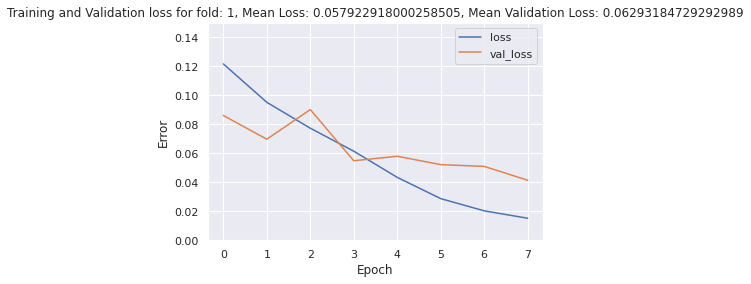

In [ ]:
import matplotlib.pyplot as plt
from statistics import mean

fold = 1

def plot_loss(fold):
  plt.plot(losses_array[fold-1], label='loss')
  plt.plot(validation_losses_array[fold-1], label='val_loss')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation loss for fold: '+str(fold)+', Mean Loss: '+str(mean(losses_array[fold-1]))+', Mean Validation Loss: '+str(mean(validation_losses_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(fold)


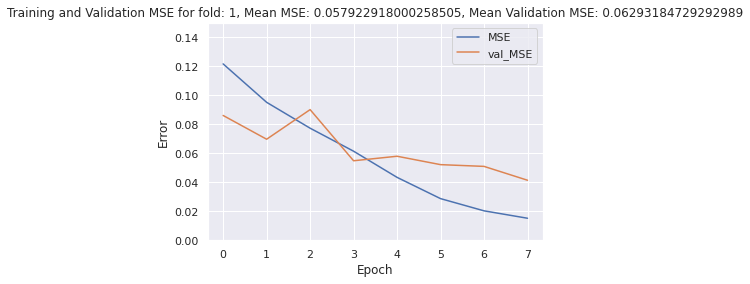

In [ ]:
def plot_mse(fold):
  plt.plot(mse_array[fold-1], label='MSE')
  plt.plot(validation_mse_array[fold-1], label='val_MSE')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation MSE for fold: '+str(fold)+', Mean MSE: '+str(mean(mse_array[fold-1]))+', Mean Validation MSE: '+str(mean(validation_mse_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_mse(fold)

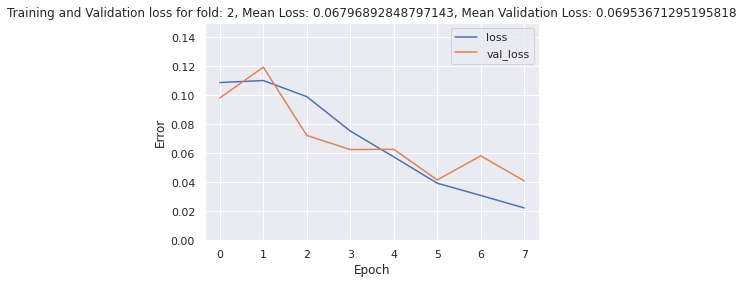

In [ ]:
fold = 2

def plot_loss(fold):
  plt.plot(losses_array[fold-1], label='loss')
  plt.plot(validation_losses_array[fold-1], label='val_loss')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation loss for fold: '+str(fold)+', Mean Loss: '+str(mean(losses_array[fold-1]))+', Mean Validation Loss: '+str(mean(validation_losses_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(fold)


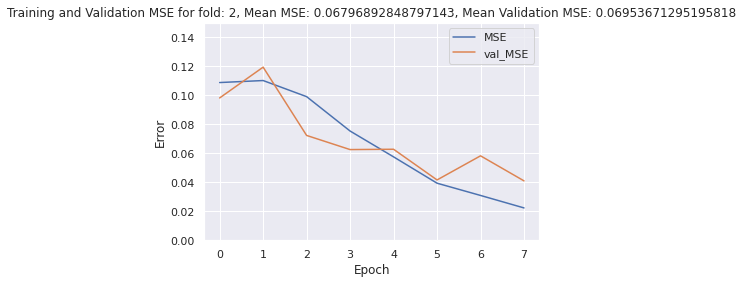

In [ ]:
def plot_mse(fold):
  plt.plot(mse_array[fold-1], label='MSE')
  plt.plot(validation_mse_array[fold-1], label='val_MSE')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation MSE for fold: '+str(fold)+', Mean MSE: '+str(mean(mse_array[fold-1]))+', Mean Validation MSE: '+str(mean(validation_mse_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_mse(fold)

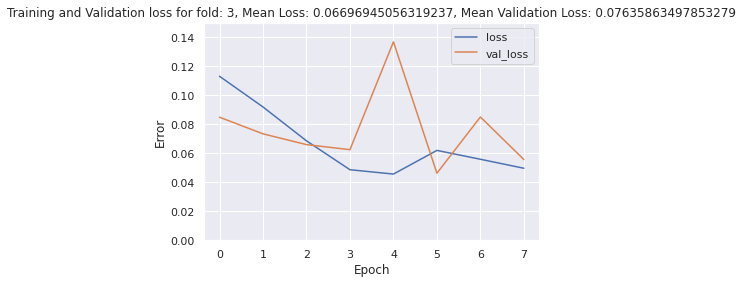

In [ ]:
fold = 3

def plot_loss(fold):
  plt.plot(losses_array[fold-1], label='loss')
  plt.plot(validation_losses_array[fold-1], label='val_loss')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation loss for fold: '+str(fold)+', Mean Loss: '+str(mean(losses_array[fold-1]))+', Mean Validation Loss: '+str(mean(validation_losses_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(fold)


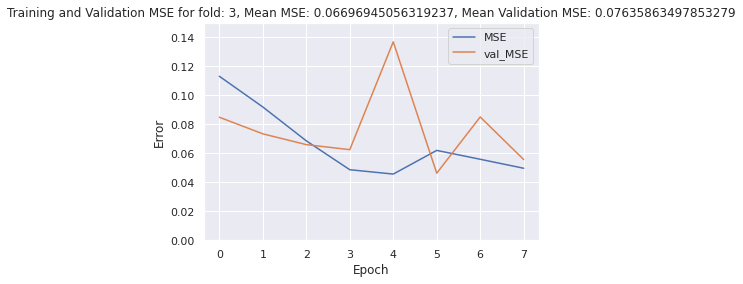

In [ ]:
def plot_mse(fold):
  plt.plot(mse_array[fold-1], label='MSE')
  plt.plot(validation_mse_array[fold-1], label='val_MSE')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation MSE for fold: '+str(fold)+', Mean MSE: '+str(mean(mse_array[fold-1]))+', Mean Validation MSE: '+str(mean(validation_mse_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_mse(fold)

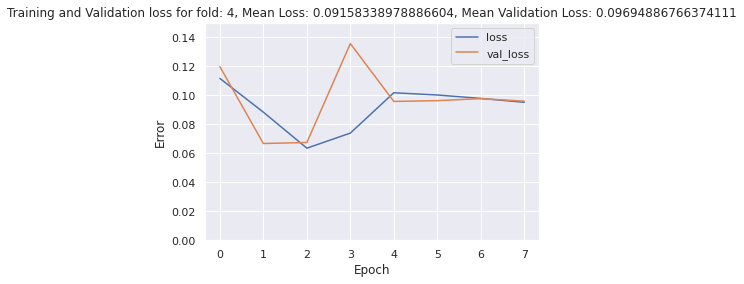

In [ ]:
fold = 4

def plot_loss(fold):
  plt.plot(losses_array[fold-1], label='loss')
  plt.plot(validation_losses_array[fold-1], label='val_loss')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation loss for fold: '+str(fold)+', Mean Loss: '+str(mean(losses_array[fold-1]))+', Mean Validation Loss: '+str(mean(validation_losses_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(fold)


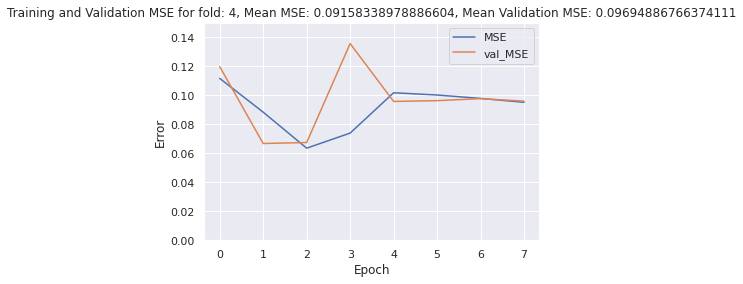

In [ ]:
def plot_mse(fold):
  plt.plot(mse_array[fold-1], label='MSE')
  plt.plot(validation_mse_array[fold-1], label='val_MSE')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation MSE for fold: '+str(fold)+', Mean MSE: '+str(mean(mse_array[fold-1]))+', Mean Validation MSE: '+str(mean(validation_mse_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_mse(fold)

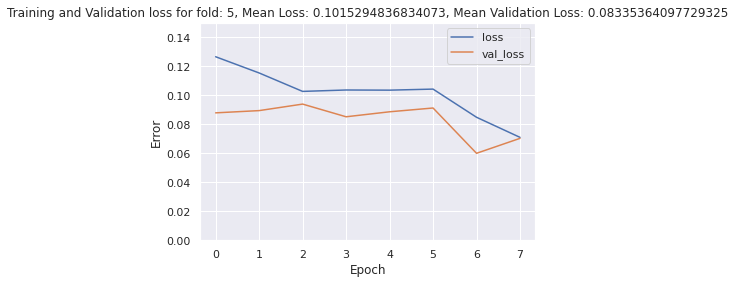

In [ ]:
fold = 5

def plot_loss(fold):
  plt.plot(losses_array[fold-1], label='loss')
  plt.plot(validation_losses_array[fold-1], label='val_loss')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation loss for fold: '+str(fold)+', Mean Loss: '+str(mean(losses_array[fold-1]))+', Mean Validation Loss: '+str(mean(validation_losses_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(fold)


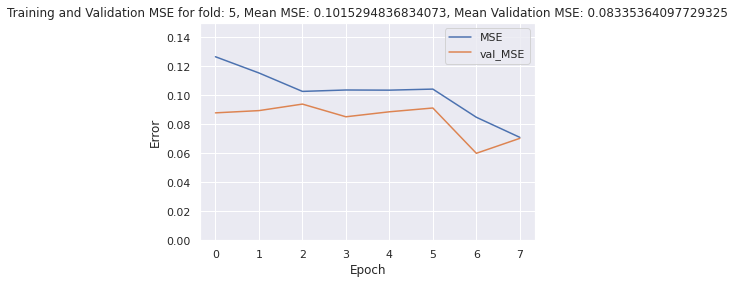

In [ ]:
def plot_mse(fold):
  plt.plot(mse_array[fold-1], label='MSE')
  plt.plot(validation_mse_array[fold-1], label='val_MSE')
  plt.ylim([0, 0.15])
  plt.title('Training and Validation MSE for fold: '+str(fold)+', Mean MSE: '+str(mean(mse_array[fold-1]))+', Mean Validation MSE: '+str(mean(validation_mse_array[fold-1])))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_mse(fold)

In [ ]:
len(train_data[1])

193

Tokenizing the Input sentences

In [ ]:
train_tokens = albert_tokens(train_data,
                            truncation=True,
                            padding=True)
validation_tokens = albert_tokens(val_data,
                            truncation=True,
                            padding=True)

Vocabulary of the ALBERT pre-trained model

In [ ]:
albert_tokens.get_vocab()

{'<pad>': 0,
 '<unk>': 1,
 '[CLS]': 2,
 '[SEP]': 3,
 '[MASK]': 4,
 '(': 5,
 ')': 6,
 '"': 7,
 '-': 8,
 '.': 9,
 '–': 10,
 '£': 11,
 '€': 12,
 '▁': 13,
 '▁the': 14,
 ',': 15,
 '▁of': 16,
 '▁and': 17,
 's': 18,
 '▁in': 19,
 '▁to': 20,
 '▁a': 21,
 "'": 22,
 '▁was': 23,
 '▁he': 24,
 '▁is': 25,
 '▁for': 26,
 '▁on': 27,
 '▁as': 28,
 '▁with': 29,
 '▁that': 30,
 '▁i': 31,
 '▁it': 32,
 '▁his': 33,
 '▁by': 34,
 '▁at': 35,
 '▁her': 36,
 '▁from': 37,
 't': 38,
 '▁she': 39,
 '▁an': 40,
 '▁had': 41,
 '▁you': 42,
 'd': 43,
 '▁be': 44,
 ':': 45,
 '▁were': 46,
 '▁but': 47,
 '▁this': 48,
 'i': 49,
 '▁are': 50,
 '▁my': 51,
 '▁not': 52,
 '▁one': 53,
 '▁or': 54,
 '▁me': 55,
 '▁which': 56,
 '▁have': 57,
 'a': 58,
 '▁they': 59,
 '?': 60,
 '▁him': 61,
 'e': 62,
 '▁has': 63,
 '▁first': 64,
 '▁all': 65,
 '▁their': 66,
 '▁also': 67,
 'ing': 68,
 'ed': 69,
 '▁out': 70,
 '▁up': 71,
 '▁who': 72,
 ';': 73,
 '▁been': 74,
 '▁after': 75,
 '▁when': 76,
 '▁into': 77,
 '▁new': 78,
 'm': 79,
 '▁there': 80,
 '▁two': 81,
 '▁

In [ ]:
len(albert_tokens.get_vocab())

30000

In [ ]:
train_tokens['input_ids'][0]

[2,
 47,
 14,
 354,
 6335,
 67,
 6347,
 1460,
 24944,
 88,
 14,
 161,
 236,
 5745,
 13,
 22,
 18,
 18232,
 68,
 23,
 9006,
 34,
 698,
 13,
 15,
 17,
 87,
 32,
 41,
 6385,
 21,
 16354,
 30,
 23811,
 83,
 130,
 44,
 13,
 1,
 166,
 8,
 6929,
 13,
 7,
 13,
 9,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
train_tokens['token_type_ids'][1]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
train_tokens['attention_mask'][1]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
print(len(train_tokens['input_ids'][1]))
print(len(train_tokens['token_type_ids'][1]))

75
75


Binding the Input tokens and Subjectiviy scores into a Tensorflow Dataset format

In [ ]:
model_train_data = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    train_scores
))

model_val_data = tf.data.Dataset.from_tensor_slices((
    dict(validation_tokens),
    val_scores
))

In [ ]:
model_train_data.element_spec

({'attention_mask': TensorSpec(shape=(75,), dtype=tf.int32, name=None),
  'input_ids': TensorSpec(shape=(75,), dtype=tf.int32, name=None),
  'token_type_ids': TensorSpec(shape=(75,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.float32, name=None))

Retrieving the Pre-trained ALBERT model

In [ ]:
albert_regression_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2',
                                                              num_labels=1)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier', 'dropout_35']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary of the model

In [ ]:
albert_regression_model.summary()

Model: "tf_albert_for_sequence_classification_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_35 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  769       
Total params: 11,684,353
Trainable params: 11,684,353
Non-trainable params: 0
_________________________________________________________________


Training the model with MSE metric

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
albert_regression_model.compile(optimizer=optimizer, loss=albert_regression_model.compute_loss, metrics=['mean_squared_error'])
history= albert_regression_model.fit(model_train_data.shuffle(100).batch(16),
          epochs=6,
          batch_size=16,
          validation_data=model_val_data.shuffle(100).batch(16))

Epoch 1/6
58/58 [==============================] - 29s 276ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.0971 - val_mean_squared_error: 0.0971
Epoch 2/6
58/58 [==============================] - 13s 230ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 0.0993 - val_mean_squared_error: 0.0993
Epoch 3/6
58/58 [==============================] - 13s 227ms/step - loss: 0.1020 - mean_squared_error: 0.1020 - val_loss: 0.1091 - val_mean_squared_error: 0.1091
Epoch 4/6
58/58 [==============================] - 13s 225ms/step - loss: 0.1035 - mean_squared_error: 0.1035 - val_loss: 0.0974 - val_mean_squared_error: 0.0974
Epoch 5/6
58/58 [==============================] - 13s 224ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
Epoch 6/6
58/58 [==============================] - 13s 225ms/step - loss: 0.0989 - mean_squared_error: 0.0989 - val_loss: 0.0967 - val_mean_squared_error: 0.0967


Saving the Model

In [ ]:
albert_regression_model.save_pretrained("/Regression/Finetuned_Albert_model")

Mean Squared Error of the Model


In [ ]:
mean_squared_error = history.history['val_mean_squared_error'][1]
print(mean_squared_error)

0.09925097972154617


RMSE of the Model


In [ ]:
import math

root_mean_squared_error = math.sqrt(mean_squared_error)
print(root_mean_squared_error)

0.31504123495432496


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

Tranining and Validaiton Loss Curves of the Model

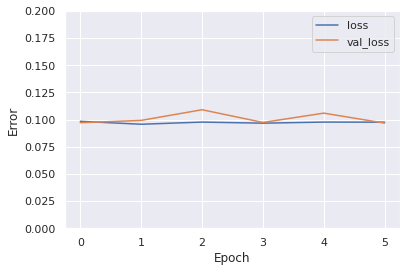

In [ ]:
plot_loss(history)

Loading the Fine-tuned Model

In [ ]:
loaded_model = TFAlbertForSequenceClassification.from_pretrained("/Regression/Finetuned_Albert_model")

Some weights of the model checkpoint at /Regression/Finetuned_Albert_model were not used when initializing TFAlbertForSequenceClassification: ['dropout_35']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at /Regression/Finetuned_Albert_model and are newly initialized: ['dropout_71']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions on the Testset

In [ ]:
test_pred = []


for sent in test_data:
  test_tokens = albert_tokens.encode(sent,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  test_pred.append(loaded_model.predict(test_tokens)[0][0][0])
print(test_pred)

[0.4543215, 0.45532984, 0.45554075, 0.45497936, 0.4534253, 0.45367205, 0.45438164, 0.45256895, 0.45493695, 0.45472008, 0.45406497, 0.45436084, 0.45399696, 0.45348158, 0.4543876, 0.4542335, 0.45587325, 0.45501822, 0.45117825, 0.45461327, 0.45275754, 0.45568812, 0.45335057, 0.45485958, 0.45490882, 0.45433897, 0.45277205, 0.45435384, 0.45418262, 0.45481622, 0.45569637, 0.45418015, 0.4552137, 0.45538032, 0.45370334, 0.4547524, 0.4531688, 0.4553076, 0.45385414, 0.4544135, 0.45412275, 0.45288008, 0.45564193, 0.45463026, 0.45465058, 0.45567992, 0.45459723, 0.4544841, 0.45233852, 0.4556238, 0.45580316, 0.45415616, 0.4545515, 0.45453486, 0.4540738, 0.4537129, 0.4551893, 0.45496592, 0.45388755, 0.45429876, 0.454021, 0.45228058, 0.45335674, 0.4542419, 0.45474285, 0.45406392, 0.45466697, 0.45204237, 0.45439965, 0.4541455, 0.45432284, 0.45481735, 0.45434588, 0.4525088, 0.4538378, 0.45358405, 0.452672, 0.4544122, 0.45461208, 0.4543058, 0.45501179, 0.45511615, 0.4515584, 0.45443258, 0.45434606, 0.453

MSE for Test Set

In [ ]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(test_scores, test_pred)
print(mse_test)

0.15749106524772497


MAE for Test Set

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_test = mean_absolute_error(test_scores, test_pred)
print(mae_test)

0.3675693508210354


RMSE for Test Data

In [ ]:
root_mean_squared_error_test = math.sqrt(mse_test)
print(root_mean_squared_error_test)

0.3968514397702558


Train the model with Mean Absolute Error Metric

In [ ]:
albert_regression_model_mae = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2',
                                                              num_labels=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
albert_regression_model_mae.compile(optimizer=optimizer, loss=albert_regression_model_mae.compute_loss, metrics=['mean_absolute_error'])
history= albert_regression_model_mae.fit(model_train_data.shuffle(100).batch(16),
          epochs=5,
          batch_size=16,
          validation_data=model_val_data.shuffle(100).batch(16))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing TFAlbertForSequenceClassification: ['predictions']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
58/58 [==============================] - 28s 268ms/step - loss: 0.1822 - mean_absolute_error: 0.3319 - val_loss: 0.0901 - val_mean_absolute_error: 0.2466
Epoch 2/5
58/58 [==============================] - 13s 231ms/step - loss: 0.1005 - mean_absolute_error: 0.2588 - val_loss: 0.0799 - val_mean_absolute_error: 0.2270
Epoch 3/5
58/58 [==============================] - 13s 230ms/step - loss: 0.1080 - mean_absolute_error: 0.2641 - val_loss: 0.0810 - val_mean_absolute_error: 0.2295
Epoch 4/5
58/58 [==============================] - 13s 227ms/step - loss: 0.0932 - mean_absolute_error: 0.2434 - val_loss: 0.0782 - val_mean_absolute_error: 0.2140
Epoch 5/5
58/58 [==============================] - 13s 225ms/step - loss: 0.0602 - mean_absolute_error: 0.1926 - val_loss: 0.0677 - val_mean_absolute_error: 0.2077


In [ ]:
mean_abs_error = history.history['val_mean_absolute_error'][1]
print(mean_abs_error)

0.22700954973697662


Tranining and Validaiton Loss Curves of the Model

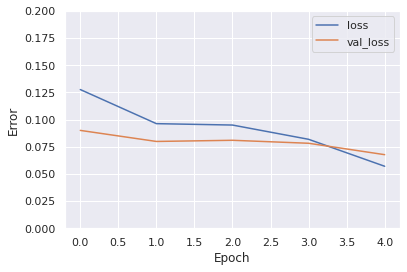

In [ ]:
plot_loss(history)

Saving the trained model

In [ ]:
albert_regression_model_mae.save_pretrained("/Regression/Finetuned_Albert_model_MAE")

Loading the Fine-tuned Model

In [ ]:
loaded_model = TFAlbertForSequenceClassification.from_pretrained("/Regression/Finetuned_Albert_model_MAE")

Some weights of the model checkpoint at /Regression/Finetuned_Albert_model_MAE were not used when initializing TFAlbertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFAlbertForSequenceClassification were not initialized from the model checkpoint at /Regression/Finetuned_Albert_model_MAE and are newly initialized: ['dropout_77']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predctions on Testset

In [ ]:
test_pred = []


for sent in test_data:
  test_tokens = albert_tokens.encode(sent,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  test_pred.append(loaded_model.predict(test_tokens)[0][0][0])
print(test_pred)

[0.70897466, 0.69902825, 0.15678202, 0.6316755, 0.16817838, 0.8070277, 0.9366032, 0.5264932, 0.33068788, 0.42363158, 0.66887856, 0.3896478, 0.50934356, 0.23477997, 0.43330017, 0.6519827, 0.78413457, 0.6553026, 0.13225321, 0.5992315, 0.3974674, 0.5423826, 0.17807181, 0.7748871, 0.8182161, 0.77112746, 0.14998136, 0.6015781, 0.41958046, 0.4529638, 0.8573079, 0.7597416, 0.73880535, 0.6186468, 0.70594746, 0.6106278, 0.71040547, 0.6167523, 0.6712632, 0.7664958, 0.6344624, 0.6102925, 0.8350302, 0.59150535, 0.6243279, 0.8833016, 0.8701523, 0.8111228, 0.3060274, 0.8357999, 0.61390567, 0.4106502, 0.79048556, 0.5707585, 0.624512, 0.7827198, 0.8526338, 0.81927633, 0.5350611, 0.7022895, 0.61731136, 0.11387959, 0.17281725, 0.5307879, 0.591902, 0.38597256, 0.74469, 0.32707745, 0.76312786, 0.2061538, 0.7938859, 0.71198416, 0.64816934, 0.565712, 0.4468596, 0.381752, 0.65992707, 0.23732494, 0.34993982, 0.7987472, 0.7373052, 0.65084946, 0.2865706, 0.75003624, 0.39063403, 0.4224176, 0.13640882, 0.5085544,

MSE for Test Set

In [ ]:
from sklearn.metrics import mean_squared_error

mse_test = mean_squared_error(test_scores, test_pred)
print(mse_test)

0.11144160274744194


MAE for Test Set

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_test = mean_absolute_error(test_scores, test_pred)
print(mae_test)

0.28136161524773995


RMSE for Test Set

In [ ]:
root_mean_squared_error_test = math.sqrt(mse_test)
print(root_mean_squared_error_test)

0.333828702701613


Another approach idea: Below Code for Extending the Albert Model Classification task by appending the Classification output of the Albert Model to a new Dense network of Feed Forward Layers to perform a Regression Task.(We can call this extension of Model but not Finetuning, so commented this code.)

In [ ]:
# sentences_list = data_frame["Sentence"].tolist()

# Class_0_Preds = []
# Class_1_Preds = []
# Class_2_Preds = []
# Class_3_Preds = []
# Class_4_Preds = []
# Class_5_Preds = []
# Class_6_Preds = []

# for sent in sentences_list:
#   predict_input = tokenizer.encode(sent,
#                                    truncation=True,
#                                    padding=True,
#                                    return_tensors="tf")
#   tf_output = loaded_model.predict(predict_input)[0]

#   Class_0_Preds.append(tf_output[0][0])
#   Class_1_Preds.append(tf_output[0][1])
#   Class_2_Preds.append(tf_output[0][2])
#   Class_3_Preds.append(tf_output[0][3])
#   Class_4_Preds.append(tf_output[0][4])
#   Class_5_Preds.append(tf_output[0][5])
#   Class_6_Preds.append(tf_output[0][6])




In [ ]:
# df = DataFrame({'Class_0':Class_0_Preds, 'Class_1':Class_1_Preds, 'Class_2':Class_2_Preds, 'Class_3':Class_3_Preds, 'Class_4':Class_4_Preds, 'Class_5':Class_5_Preds, 'Class_6':Class_6_Preds})

In [ ]:
# len(df)

In [ ]:
# from textblob import TextBlob

# def getScore(data):
#   return TextBlob(data).sentiment.subjectivity

# df["Subj_Score"] = data_frame["Sentence"].apply(getScore)

In [ ]:
# df.head()

In [ ]:
# tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()[0]
# print(tf_prediction)

# # 9.9978644e-01 = 0.99978644
# # 2.1356659e-04 = 0.00021356659
# # => sentiment = 0

In [ ]:
# X = df.iloc[:, 0:7].values
# y = df.iloc[:, 7].values

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
# print(y)

Ref: https://stackabuse.com/tensorflow-2-0-solving-classification-and-regression-problems/

In [ ]:
# from tensorflow.keras.layers import Input, Dense, Activation,Dropout
# from tensorflow.keras.models import Model

# input_layer = Input(shape=(X.shape[1],))
# dense_layer_1 = Dense(100, activation='relu')(input_layer)
# dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
# dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
# output = Dense(1)(dense_layer_3)

# model = Model(inputs=input_layer, outputs=output)
# model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
# history = model.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2)

References:

1. TensorFlow  Datasets,  A  collection  of  ready-to-use  datasets.https://www.tensorflow.org/datasets.64

2. Source code for transformers.models.albert.tokenizationalbert. Accessed: 2021-03-14.url:https://huggingface.co/transformers/_modules/transformers/models/albert/tokenization_albert.html#AlbertTokenizer.

3. Source code for transformers.models.albert.modelingtfalbert. Accessed: 2021-03-14.url:https://huggingface.co/transformers/_modules/transformers/models/albert/modeling_tf_albert.html#TFAlbertForSequenceClassification.

4. Huggingface Distilbert - https://colab.research.google.com/drive/1yi9N-ZnQHtYfR3QDiwsPxYCYU6WyjwlQ#scrollTo=633fetsKg5cv

5. Huggingface  ALBERT  pre-trained  Model. Accessed: 2021-03-14.url:https://huggingface.co/albert-base-v2/resolve/main/spiece.model.

6. Huggingface  ALBERT  Base  version  2  Model  Usage.  Accessed:  2021-03-14.url: https://huggingface.co/albert-base-v2.